In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install statsmodels==0.11.1
!pip install fbprophet

In [3]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

In [4]:
# 평가 척도
def MSE(y, y_pred):
  return np.square(np.subtract(y, y_pred)).mean()

def RMSE(y, y_pred):
  return np.sqrt(np.square(np.subtract(y, y_pred)).mean())

# 1. 기존 데이터

## 데이터 불러오기

In [5]:
data_path = '/content/drive/MyDrive/dacon'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")

In [12]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.999389,0.999630,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1,9,0.999593,1.000000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999
2,0,2,9,0.999266,0.999618,0.999262,0.999322,0.003942,31.981472,0.016630,0.002967,24.069899
3,0,3,9,0.999322,0.999388,0.998917,0.999387,0.003663,29.709074,0.019463,0.002362,19.158766
4,0,4,9,0.999015,0.999015,0.997631,0.998399,0.003266,26.466251,0.030180,0.001533,12.421005
...,...,...,...,...,...,...,...,...,...,...,...,...
919315,7660,115,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
919316,7660,116,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
919317,7660,117,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
919318,7660,118,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


In [6]:
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]

In [7]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [8]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)

In [9]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
''')


train_x_array (300, 1380, 10)
train_y_array (300, 120, 10)



## 샘플 확인하기

In [10]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

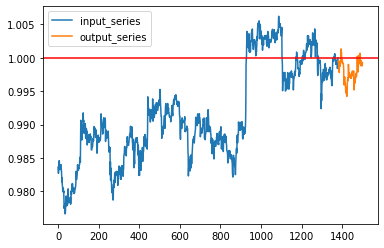

In [ ]:
# sample_id 0에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 0
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

## 모델 학습하기

### 1) train 샘플 학습

In [11]:
start_time = '2020-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

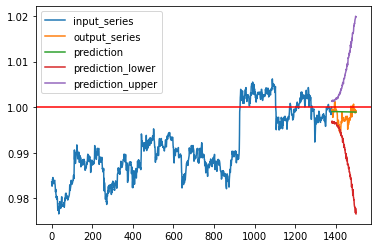

In [ ]:
# pred_y = forecast_data.yhat.values[-120:]
# pred_y_lower = forecast_data.yhat_lower.values[-120:]
# pred_y_upper = forecast_data.yhat_upper.values[-120:]

# plot_series(x_series, y_series)
# plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
# plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
# plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
# plt.legend()
# plt.show()

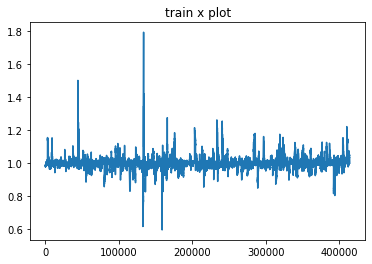

In [12]:
plt.plot(train_x_df['open'])
plt.title("train x plot")
plt.show()

In [13]:
print(train_x_df['open'].mean())
print(train_x_df['open'].max())
print(train_x_df['open'].min())

1.0023783725881634
1.792324423789978
0.5964912176132202


In [14]:
# 학습 및 추론하기

train_pred_array = np.zeros([train_x_array.shape[0], 120])

for idx in tqdm(range(train_x_array.shape[0])):
    try:
        x_series = train_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        train_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [17:20<00:00,  3.47s/it]


In [15]:
print(train_pred_array)

[[0.99906835 0.99906726 0.99906616 ... 0.99893977 0.99893867 0.99893757]
 [1.00037685 1.00039379 1.00041073 ... 1.00235861 1.00237555 1.00239249]
 [0.98289194 0.98253665 0.98218135 ... 0.94132228 0.94096699 0.94061169]
 ...
 [0.97751989 0.97695033 0.97638077 ... 0.91088118 0.91031162 0.90974205]
 [1.00052329 1.00052048 1.00051766 ... 1.00019415 1.00019133 1.00018852]
 [1.00213054 1.00201475 1.00189895 ... 0.98858232 0.98846653 0.98835073]]


In [16]:
train_pred_array.max()

1.0847833510996001

In [27]:
print(train_y_array.shape)
print(train_y_array[:,:,1].shape)
print(train_pred_array.shape)

(300, 120, 10)
(300, 120)
(300, 120)


In [28]:
print("기존 데이터")
print("MSE: ", MSE(train_y_array[:,:,1], train_pred_array))
print("RMSE: ", RMSE(train_y_array[:,:,1], train_pred_array))

기존 데이터
MSE:  0.0003892499281561193
RMSE:  0.019729417836219072


# 2. 표준화 데이터

In [29]:
# 데이터 불러오기
std_train_x_df = pd.read_csv(data_path  + "/std_train_x_df.csv")
std_train_y_df = pd.read_csv(data_path  + "/std_train_y_df.csv")

In [30]:
std_train_x_df = std_train_x_df[std_train_x_df.sample_id < 300]
std_train_y_df = std_train_y_df[std_train_y_df.sample_id < 300]

In [31]:
std_train_x_array = df2d_to_array3d(std_train_x_df)
std_train_y_array = df2d_to_array3d(std_train_y_df)

In [32]:
print(f'''
std_train_x_array {std_train_x_array.shape}
std_train_y_array {std_train_y_array.shape}
''')


std_train_x_array (300, 1380, 10)
std_train_y_array (300, 120, 10)



In [33]:
# 학습 및 추론하기

std_train_pred_array = np.zeros([std_train_x_array.shape[0], 120])

for idx in tqdm(range(std_train_x_array.shape[0])):
    try:
        x_series = std_train_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        std_train_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [14:07<00:00,  2.82s/it]


In [34]:
print(std_train_pred_array)

[[-0.05186669 -0.05221187 -0.05255705 ... -0.09225284 -0.09259802
  -0.0929432 ]
 [ 0.02550981  0.02623484  0.02695988 ...  0.1103389   0.11106393
   0.11178897]
 [-0.49759355 -0.50735522 -0.51711688 ... -1.63970846 -1.64947012
  -1.65923179]
 ...
 [-0.37425371 -0.3833017  -0.39234968 ... -1.43286796 -1.44191594
  -1.45096393]
 [-0.01532334 -0.0150286  -0.01473385 ...  0.01916163  0.01945637
   0.01975112]
 [ 0.03452636  0.0311824   0.02783844 ... -0.35671678 -0.36006074
  -0.3634047 ]]


In [35]:
std_train_pred_array.max()

2.7375372259585853

In [37]:
print("표준화 데이터")
print("MSE: ", MSE(std_train_y_array[:,:,1], std_train_pred_array))
print("RMSE: ", RMSE(std_train_y_array[:,:,1], std_train_pred_array))

표준화 데이터
MSE:  0.2606987247327116
RMSE:  0.5105866476247803


# 3. 정규화 데이터

In [38]:
# 데이터 불러오기
norm_train_x_df = pd.read_csv(data_path  + "/norm_train_x_df.csv")
norm_train_y_df = pd.read_csv(data_path  + "/norm_train_y_df.csv")

In [39]:
norm_train_x_df = norm_train_x_df[norm_train_x_df.sample_id < 300]
norm_train_y_df = norm_train_y_df[norm_train_y_df.sample_id < 300]

In [40]:
norm_train_x_array = df2d_to_array3d(norm_train_x_df)
norm_train_y_array = df2d_to_array3d(norm_train_y_df)

In [41]:
print(f'''
norm_train_x_array {norm_train_x_array.shape}
norm_train_y_array {norm_train_y_array.shape}
''')


norm_train_x_array (300, 1380, 10)
norm_train_y_array (300, 120, 10)



In [42]:
# 학습 및 추론하기

norm_train_pred_array = np.zeros([norm_train_x_array.shape[0], 120])

for idx in tqdm(range(norm_train_x_array.shape[0])):
    try:
        x_series = norm_train_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        norm_train_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [18:06<00:00,  3.62s/it]


In [43]:
print(norm_train_pred_array)

[[0.32998029 0.32997673 0.32997318 ... 0.32956452 0.32956096 0.32955741]
 [0.33205929 0.33208303 0.33210677 ... 0.33483671 0.33486045 0.33488419]
 [0.42591587 0.42555842 0.42520097 ... 0.38409398 0.38373653 0.38337907]
 ...
 [0.25950885 0.25912463 0.25874042 ... 0.21455546 0.21417124 0.21378702]
 [0.27493049 0.27493013 0.27492976 ... 0.27488802 0.27488766 0.2748873 ]
 [0.52948428 0.52936811 0.52925195 ... 0.51589304 0.51577688 0.51566071]]


In [44]:
norm_train_pred_array.max()

0.7843107370121822

In [45]:
print("정규화 데이터")
print("MSE: ", MSE(norm_train_y_array[:,:,1], norm_train_pred_array))
print("RMSE: ", RMSE(norm_train_y_array[:,:,1], norm_train_pred_array))

정규화 데이터
MSE:  0.000480064617853847
RMSE:  0.02191037694458603


# 4. 표준화 + 정규화 데이터

In [46]:
# 데이터 불러오기
std_norm_train_x_df = pd.read_csv(data_path  + "/std_norm_train_x_df.csv")
std_norm_train_y_df = pd.read_csv(data_path  + "/std_norm_train_y_df.csv")

In [47]:
std_norm_train_x_df = std_norm_train_x_df[std_norm_train_x_df.sample_id < 300]
std_norm_train_y_df = std_norm_train_y_df[std_norm_train_y_df.sample_id < 300]

In [48]:
std_norm_train_x_array = df2d_to_array3d(std_norm_train_x_df)
std_norm_train_y_array = df2d_to_array3d(std_norm_train_y_df)

In [49]:
print(f'''
std_norm_train_x_array {std_norm_train_x_array.shape}
std_norm_train_y_array {std_norm_train_y_array.shape}
''')


std_norm_train_x_array (300, 1380, 10)
std_norm_train_y_array (300, 120, 10)



In [50]:
# 학습 및 추론하기

std_norm_train_pred_array = np.zeros([std_norm_train_x_array.shape[0], 120])

for idx in tqdm(range(std_norm_train_x_array.shape[0])):
    try:
        x_series = std_norm_train_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        std_norm_train_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [17:39<00:00,  3.53s/it]


In [51]:
print(std_norm_train_pred_array)

[[0.33000721 0.33000389 0.33000057 ... 0.32961887 0.32961555 0.32961223]
 [0.33205409 0.3320778  0.3321015  ... 0.33482751 0.33485121 0.33487492]
 [0.42597271 0.42561573 0.42525875 ... 0.38420622 0.38384924 0.38349226]
 ...
 [0.25954872 0.25916465 0.25878058 ... 0.21461217 0.2142281  0.21384402]
 [0.27495039 0.27495023 0.27495008 ... 0.27493232 0.27493216 0.27493201]
 [0.52948056 0.52936434 0.52924813 ... 0.51588334 0.51576712 0.51565091]]


In [52]:
std_norm_train_pred_array.max()

0.7843356080080743

In [53]:
print("표준화 + 정규화 데이터")
print("MSE: ", MSE(std_norm_train_y_array[:,:,1], std_norm_train_pred_array))
print("RMSE: ", RMSE(std_norm_train_y_array[:,:,1], std_norm_train_pred_array))

표준화 + 정규화 데이터
MSE:  0.0004814788251062087
RMSE:  0.02194262575687351


# Submission

In [56]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantity와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)


    # 105% 이상 상승한다고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1

    # # 이 부분 개선 필요
    # for i in range(idx+1):
    #   if buy_price[i] > 1.13:
    #     submission.loc[i, 'buy_quantity'] = 1
    #   elif buy_price[i] > 1.1:
    #     submission.loc[i, 'buy_quantity'] = 0.8
    #   elif buy_price[i] > 1.06:
    #     submission.loc[i, 'buy_quantity'] = 0.5
    #   else:
    #     submission.loc[i, 'buy_quantity'] = 0



    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [55]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

NameError: ignored

In [ ]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0.0,0
1,1,0.0,119
2,2,0.0,0
3,3,0.0,0
4,4,0.0,119
...,...,...,...
295,295,0.0,119
296,296,0.0,0
297,297,0.0,0
298,298,0.0,0


In [ ]:
# 전체 300가지 sample에 대해
# 5가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0.0    296
0.5      4
Name: buy_quantity, dtype: int64

In [ ]:
# 투자 후 금액 계산하기

def df2d_to_answer(df_2d):
    # valid_y_df로부터 open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_money      = 10000 # dolors
    total_money_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_money
        residual = total_money - buy_quantity
        ratio = sell_price / buy_price
        total_money = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_money_list.append(total_money)
        
    return total_money, total_money_list

In [ ]:
total_money, total_money_list = COIN(valid_y_df,
                                     valid_submission)

In [ ]:
# 투자 후 금액
print(total_money)

10036.273104929032


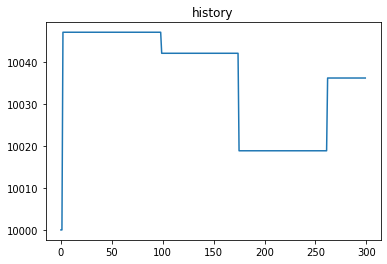

In [ ]:
# 투자 히스토리
plt.plot(total_money_list)
plt.title("history")
plt.show()

#### 값 확인

In [ ]:
# valid_pred_array[1]

array([1.00037685, 1.00039379, 1.00041073, 1.00042766, 1.0004446 ,
       1.00046154, 1.00047848, 1.00049542, 1.00051235, 1.00052929,
       1.00054623, 1.00056317, 1.00058011, 1.00059705, 1.00061398,
       1.00063092, 1.00064786, 1.0006648 , 1.00068174, 1.00069867,
       1.00071561, 1.00073255, 1.00074949, 1.00076643, 1.00078336,
       1.0008003 , 1.00081724, 1.00083418, 1.00085112, 1.00086806,
       1.00088499, 1.00090193, 1.00091887, 1.00093581, 1.00095275,
       1.00096968, 1.00098662, 1.00100356, 1.0010205 , 1.00103744,
       1.00105437, 1.00107131, 1.00108825, 1.00110519, 1.00112213,
       1.00113907, 1.001156  , 1.00117294, 1.00118988, 1.00120682,
       1.00122376, 1.00124069, 1.00125763, 1.00127457, 1.00129151,
       1.00130845, 1.00132538, 1.00134232, 1.00135926, 1.0013762 ,
       1.00139314, 1.00141008, 1.00142701, 1.00144395, 1.00146089,
       1.00147783, 1.00149477, 1.0015117 , 1.00152864, 1.00154558,
       1.00156252, 1.00157946, 1.00159639, 1.00161333, 1.00163

In [ ]:
# np.argmax(valid_pred_array[1])

119

In [ ]:
# np.argmax(valid_pred_array, axis = 1)

array([  0, 119,   0,   0, 119,   0,   0, 119, 119,   0, 119,   0,   0,
       119, 119,   0,   0,   0,   0,   0, 119, 119,   0, 119,   0, 119,
         0,   0, 119, 119])

## Test 데이터 학습 및 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,1]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=False)
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 535/535 [31:43<00:00,  3.56s/it]


In [ ]:
print(test_pred_array)

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

[1.00938768 1.04189901 1.01346971 1.0254275  1.00103199 1.02421735
 1.03310867 0.99857696 0.97567699 0.98813965 0.99380723 0.99687367
 1.00859237 0.99789956 0.99699097 1.01092058 0.97667773 0.9977463
 1.00796956 1.01114591 0.98464795 0.9941642  1.00705257 0.99037031
 1.01293194 0.99246432 0.99190574 0.99814575 0.99238994 0.99398928
 1.02456392 0.99767613 1.0129335  1.01375593 1.01005359 1.00149983
 1.00393895 1.00707868 0.95203518 1.01360036 1.00807766 0.9934601
 0.96330431 1.00267284 1.00487862 1.02772635 0.98741218 1.00129427
 1.08883926 1.07551509 1.00766307 0.99901904 1.02868934 0.99619606
 0.97249526 1.00904877 1.01743268 0.99998069 1.0075083  1.020326
 1.01186454 0.98983075 1.01837541 1.01473285 0.95454909 1.00839377
 0.99544963 0.99636718 0.99665607 1.00393297 1.01310429 0.99051179
 1.00402037 0.99885009 0.94533753 0.99145765 0.96700195 0.99307287
 0.99423852 1.02266741 0.99712261 0.98451984 1.00129362 0.99060449
 1.01496193 1.0035917  1.00990928 1.00688586 1.02056623 1.00141027

In [ ]:
submission.to_csv(data_path+"/baseline_submission_proh.csv", index = False) # 결과 csv 파일 생성

In [ ]:
submission.buy_quantity.value_counts()

0.0    531
0.5      4
Name: buy_quantity, dtype: int64